In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
#import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
# size = 224
train_transform = transforms.Compose([transforms.Resize(256), 
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     ])
test_transform = transforms.Compose([transforms.Resize(256), 
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                                     
                                     ])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

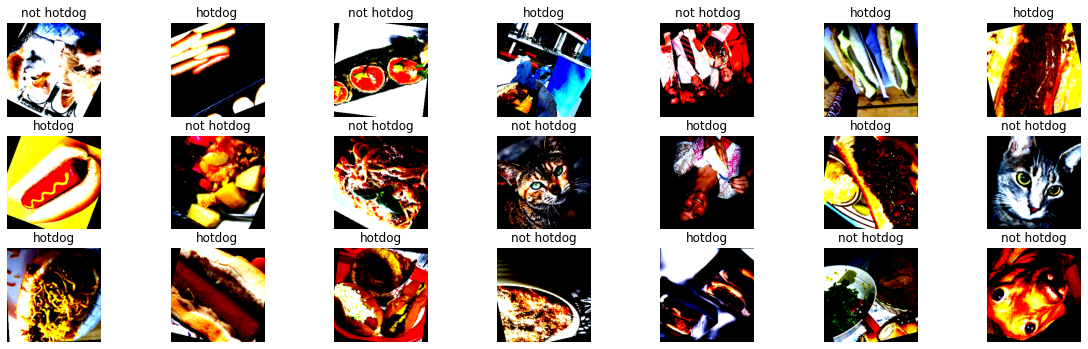

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        wandb.log({"train_acc": out_dict['train_acc'][-1],
                  "test_acc": out_dict['test_acc'][-1],
                  "train_loss": out_dict['train_loss'][-1],
                   "test_loss": out_dict['test_loss'][-1]})      
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 6:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [7]:
class VGG_Network(nn.Module):
    def __init__(self):
        super(VGG_Network, self).__init__()       
        
        self.convolutional = nn.Sequential(
               nn.Conv2d(3, 64, 3, stride=1, padding=1),
               #nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.Conv2d(64, 64, 3, stride=1, padding=1),
               #nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(64, 128, 3, stride=1, padding=1),
               #nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.Conv2d(128, 128, 3, stride=1, padding=1),
               #nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(128, 256, 3, stride=1, padding=1),
               #nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               #nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               #nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(256, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               #nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2)
               )

        self.fully_connected = nn.Sequential(
                nn.Linear(7*7*512, 4096),               
                nn.ReLU(),            
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 4096),              
                nn.ReLU(),
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 2))
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [8]:
class VGG_BN_Network(nn.Module):
    def __init__(self):
        super(VGG_BN_Network, self).__init__()       
        
        self.convolutional = nn.Sequential(
               nn.Conv2d(3, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.Conv2d(64, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(64, 128, 3, stride=1, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.Conv2d(128, 128, 3, stride=1, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(128, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(256, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2)
               )

        self.fully_connected = nn.Sequential(
                nn.Linear(7*7*512, 4096),               
                nn.ReLU(),            
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 4096),              
                nn.ReLU(),
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 2))
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [9]:
model = VGG_Network()
model_BN = VGG_BN_Network()

model.to(device)
model_BN.to(device)

#Initialize the optimizer
#SGD_lr = 0.001
ADAM_lr = 0.00001
ADAM_BN_lr = 0.000001
#optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer = torch.optim.Adam(model.parameters(),lr=ADAM_lr)
optimizer_BN = torch.optim.Adam(model_BN.parameters(),lr=ADAM_BN_lr)

num_epoch = 50

In [10]:
#wandb.init(project="Hotdog2", name="VGG", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": ADAM_lr,
#  "epochs": num_epoch,
#  "optimizer" : "ADAM",
#  "predefined" : False,
#  "data_augmentation" : True,    
#  "batch_norm" : False, 
#  "dropout" : False 
#})

out_dict = train(model, optimizer, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='VGG Test Acc')
ax[0].plot(out_dict["train_acc"], label='VGG Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
 

ax[1].plot(out_dict["test_loss"], label='VGG Test Loss')
ax[1].plot(out_dict["train_loss"], label='VGG Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

#wandb.init(project="Hotdog2", name="VGG_BN", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": ADAM_BN_lr,
#  "epochs": num_epoch,
#  "optimizer" : "ADAM",
#  "predefined" : False,
#  "data_augmentation" : True,
#  "batch_norm" : True, 
#  "dropout" : False     
#})
out_dict = train(model_BN, optimizer_BN, num_epoch)
ax[0].plot(out_dict["test_acc"], label='VGG_BN Test Acc')
ax[0].plot(out_dict["train_acc"], label='VGG_BN Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='VGG_BN Test Loss')
ax[1].plot(out_dict["train_loss"], label='VGG_BN Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()

wandb: Currently logged in as: gizemggungor. Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.696	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.690	 test: 0.690	 Accuracy train: 52.5%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.624	 test: 0.609	 Accuracy train: 66.5%	 test: 69.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.559	 test: 0.592	 Accuracy train: 73.0%	 test: 68.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.538	 test: 0.564	 Accuracy train: 74.5%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.557	 Accuracy train: 74.7%	 test: 70.8%


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 